In [1]:
import pickle

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import skimage
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import metrics
from scipy import signal
import tqdm

In [2]:
matplotlib.rcParams["image.cmap"] = 'gray' # 'hot'
rng = np.random.default_rng()

In [3]:
def get_image_path(name):
    return f'./data/train_512/{name}.jpg'
    # return f'./data/train/{name}.jpg'

def get_image(name):
    return skimage.io.imread(get_image_path(name))

def make_segment(image: np.array, *, window_size=64) -> np.array:
    y_size, x_size, *_ = image.shape
    x_start = (x_size - window_size) // 2
    x_end = x_start + window_size
    y_start = (y_size - window_size) // 2
    y_end = y_start + window_size
    return image[y_start:y_end, x_start:x_end]

def resize_image(image, size=128):
    image = make_segment(image, window_size=min(image.shape[:2]))
    aa = False # True
    image = skimage.transform.resize(image, (size, size), anti_aliasing=aa)
    image = np.around(image * 255).astype(int)
    return image

def equalize_hist(image):
    return np.array([
        skimage.exposure.equalize_hist(image[:, :, 0]),
        skimage.exposure.equalize_hist(image[:, :, 1]),
        skimage.exposure.equalize_hist(image[:, :, 2])
    ]).transpose((1, 2, 0))

def make_greyscale(image):
    # Y = 0.2125 R + 0.7154 G + 0.0721 B
    return 0.2125*image[:,:,0] + 0.7154*image[:,:,1] + 0.0721*image[:,:,2]
    # return skimage.color.rgb2gray(image)

def make_features(image: np.array, **kwargs) -> np.array:
    """**kwargs are passed to make_segment function."""
    return make_segment(image, **kwargs).flatten()

In [4]:
BLUE = '#1f77b4'
ORANGE = '#ff7f0e'
GREEN = '#2ca02c'
RED = '#d62728'
PURPLE = '#9467bd'
BROWN = '#8c564b'
PINK = '#e377c2'
GREY = '#7f7f7f'
OLIVE = '#bcbd22'
CYAN = '#17becf'
COLORS_RGB = [RED, GREEN, BLUE]

def show_rgb(image):
    fig, axs = plt.subplots(2, 3, figsize=(9, 6))
    axs[0, 0].imshow(image)
    axs[0, 0].set_title('original')

    axs[0, 1].imshow(image.mean(axis=2))
    axs[0, 1].set_title('mean')

    # Y = 0.2125 R + 0.7154 G + 0.0721 B
    axs[0, 2].imshow(skimage.color.rgb2gray(image))
    axs[0, 2].set_title('grayscale')

    axs[1, 0].imshow(image[:, :, 0])
    axs[1, 0].set_title('red')

    axs[1, 1].imshow(image[:, :, 1])
    axs[1, 1].set_title('green')

    axs[1, 2].imshow(image[:, :, 2])
    axs[1, 2].set_title('blue')

def show_hist(image):
    plt.show()
    plt.hist(image.flatten(), alpha=0.4, color=GREY)
    plt.hist(image[:, :, 0].flatten(), alpha=0.4, color=RED)
    plt.hist(image[:, :, 1].flatten(), alpha=0.4, color=GREEN)
    plt.hist(image[:, :, 2].flatten(), alpha=0.4, color=BLUE)

In [5]:
truth_frame = pd.read_csv('./data/ISIC_2020_Training_GroundTruth.csv')
truth_frame

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
...,...,...,...,...,...,...,...,...
33121,ISIC_9999134,IP_6526534,male,50.0,torso,unknown,benign,0
33122,ISIC_9999320,IP_3650745,male,65.0,torso,unknown,benign,0
33123,ISIC_9999515,IP_2026598,male,20.0,lower extremity,unknown,benign,0
33124,ISIC_9999666,IP_7702038,male,50.0,lower extremity,unknown,benign,0


In [6]:
truth_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


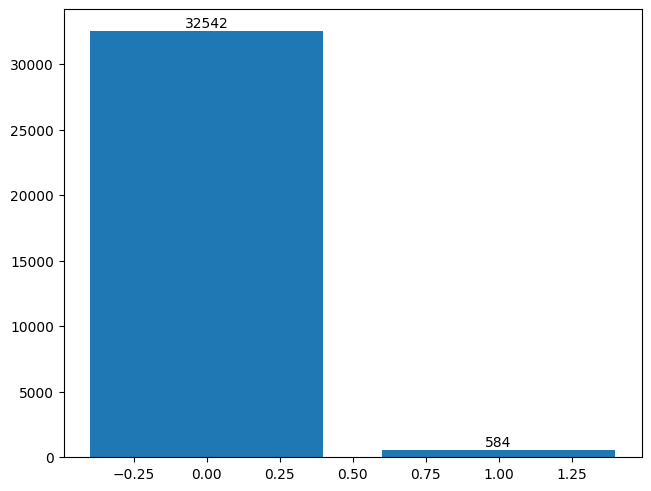

In [7]:
fig, ax = plt.subplots(layout='constrained')
frame = truth_frame.target.value_counts()
bars = ax.bar(frame.index, frame.values)
_ = ax.bar_label(bars)

In [8]:
positive = truth_frame.query('target == 1')
negative = truth_frame.query('target == 0').sample(n=positive.shape[0])
balanced_df = pd.concat([positive, negative])
balanced_df

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1
...,...,...,...,...,...,...,...,...
11738,ISIC_3611014,IP_9053225,female,55.0,torso,unknown,benign,0
568,ISIC_0277727,IP_8326844,female,60.0,lower extremity,unknown,benign,0
18844,ISIC_5722194,IP_3423256,female,60.0,torso,unknown,benign,0
17015,ISIC_5198780,IP_4522475,male,30.0,torso,nevus,benign,0


Text(0.5, 1.0, 'target=0')

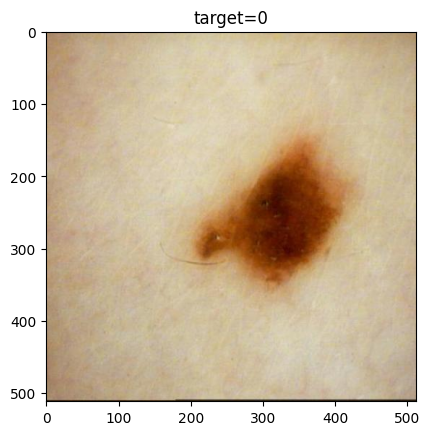

In [9]:
sample_row = balanced_df.sample(1)
target = sample_row.target.item()
image_name = sample_row.image_name.item() 

target, image_name

image = get_image(image_name)
plt.imshow(image)
plt.title(f'{target=}')

Text(0.5, 1.0, 'target=0')

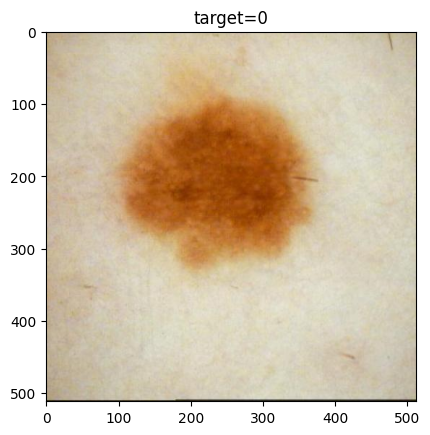

In [10]:
#image_name = 'ISIC_4525317'
sample_row = balanced_df.sample(1)
image_name_2 = sample_row.image_name.item() 
target_2 = sample_row.target.item()

image_2 = get_image(image_name_2)
plt.imshow(image_2)
plt.title(f'{target=}')

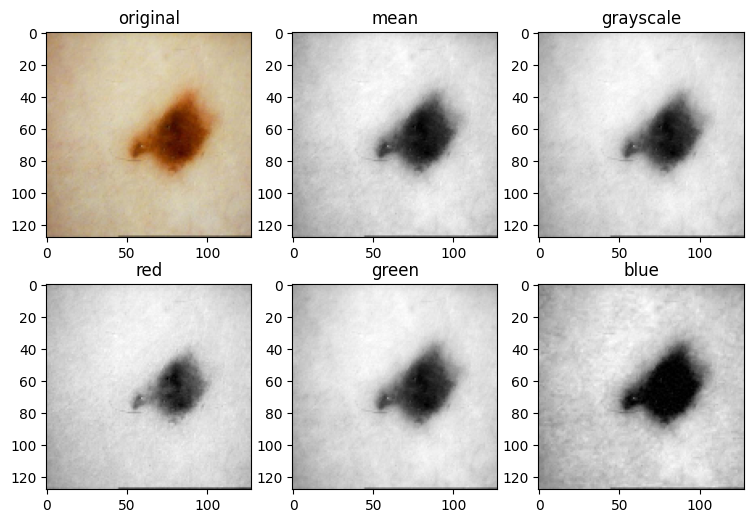

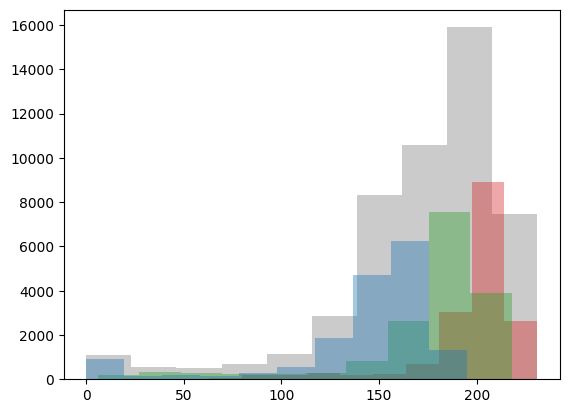

In [11]:
SIZE = 128
image = resize_image(image, size=SIZE)
show_rgb(image)
show_hist(image)

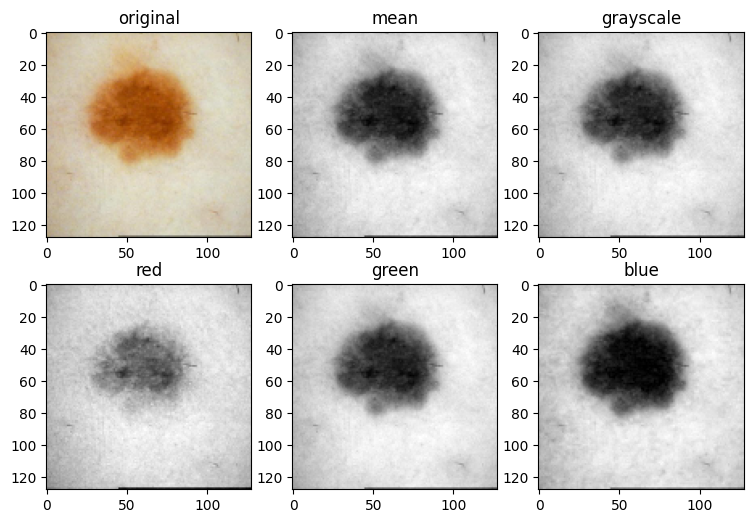

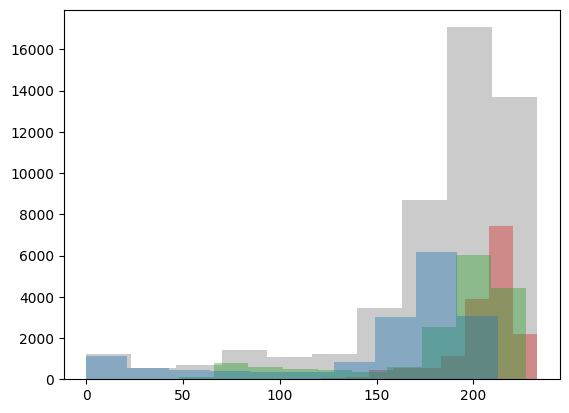

In [12]:
image_2 = resize_image(image_2, size=SIZE)
show_rgb(image_2)
show_hist(image_2)

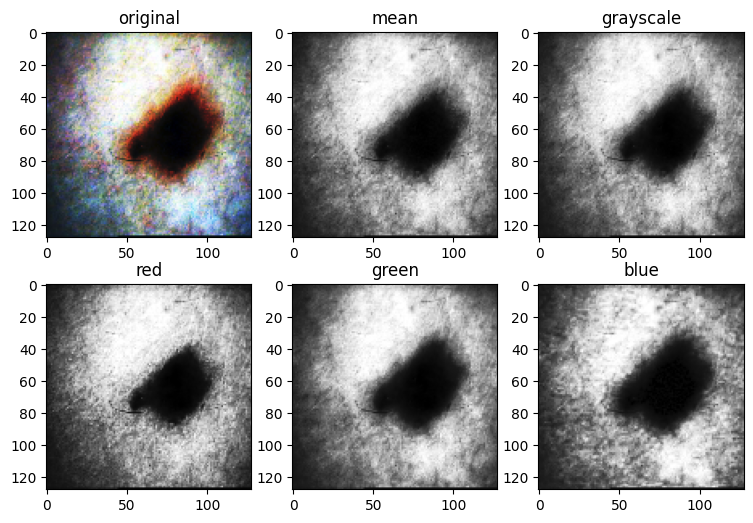

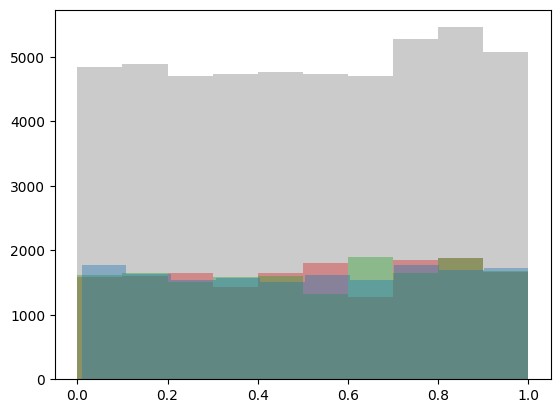

In [13]:
image = equalize_hist(image)
show_rgb(image)
show_hist(image)

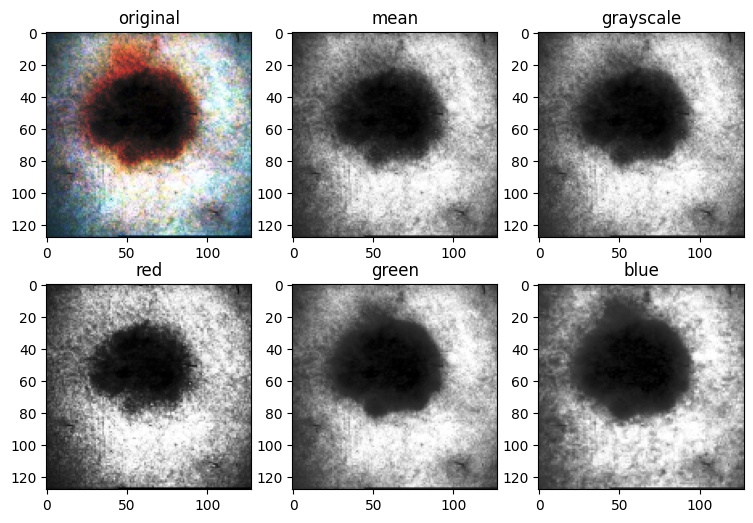

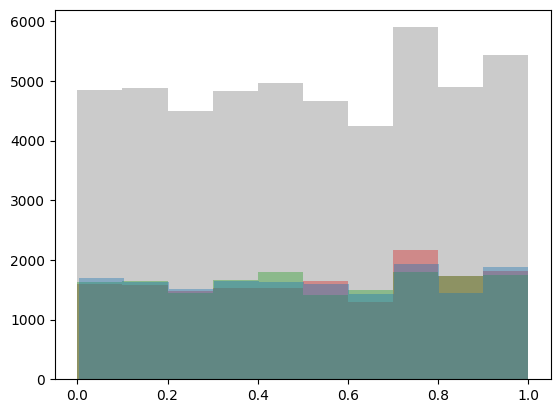

In [14]:
image_2 = equalize_hist(image_2)
show_rgb(image_2)
show_hist(image_2)

In [15]:
T = 8 # Number of gradient orientations
M = 6 # Number of Excitation bins
# WEIGHTS = (0.2688, 0.0852, 0.0955, 0.1000, 0.1018, 0.3487)
WEIGHTS = [1/M for i in range(M)]
S = 20 # Granularity of excitation per gradient orientation group

def apply_f00(matrix):
    f00 = np.array([[1,  1,  1],
                    [1, -8,  1],
                    [1,  1,  1]])
    return signal.convolve2d(matrix, f00, mode='valid')

def apply_f01(matrix):
    return matrix[1:-1, 1:-1]

def apply_f10(matrix):
    f10 = np.array([[0, -1,  0],
                    [0,  0,  0],
                    [0,  1,  0]])
    return signal.convolve2d(matrix, f10, mode='valid')

def apply_f11(matrix):
    f11 = np.array([[0,  0,  0],
                    [1,  0, -1],
                    [0,  0,  0]])
    return signal.convolve2d(matrix, f11, mode='valid')

def get_differential_excitation(matrix):
    v00 = apply_f00(matrix)
    v01 = apply_f01(matrix)
    # return np.divide(v00, v01)
    return np.arctan(np.divide(v00, v01))
    #return np.arctan2(v00, v01)

def arctan2(v11, v10):
    theta = np.arctan(np.divide(v11, v10))
    if v11 > 0 and v10 > 0:
        return theta
    elif v11 > 0 and v10 < 0:
        return np.pi + theta
    elif v11 < 0 and v10 < 0:
        return theta - np.pi
    else:
        return theta

def big_theta_t(v11, v10):
    theta = np.arctan2(v11, v10)
    theta_1 = theta + np.pi
    # return theta_1
    t = np.mod(np.floor(theta_1*T/(2*np.pi) + 1/2), T)
    theta_t = 2*t*np.pi / T
    return theta_t

def get_gradient_orientation(matrix):
    v11 = apply_f11(matrix)
    v10 = apply_f10(matrix)
    return big_theta_t(v11, v10)

def show_excit_and_grad(image):
    fig, axs = plt.subplots(2, 3, figsize=(10, 4))
    axs[0, 0].imshow(image)
    image = make_greyscale(image)
    grad_ori = get_gradient_orientation(image)
    diff_excit = get_differential_excitation(image)

    excit_range=[-np.pi/2, np.pi/2]
    counts, edges, ax = axs[0, 1].hist(diff_excit.flatten(), bins=M*S, range=excit_range)
    
    grad_range=[0, 2*np.pi]
    axs[0, 2].hist(grad_ori.flatten(), bins=T, range=grad_range)

    axs[1, 0].imshow(image)
    axs[1, 1].imshow(diff_excit)
    axs[1, 2].imshow(grad_ori)


def get_wld_histogram(image_name):
    image = get_image(image_name)
    image = resize_image(image, SIZE)
    image = equalize_hist(image)
    image = make_greyscale(image)
    grad_ori = get_gradient_orientation(image)
    diff_excit = get_differential_excitation(image)

    grad_range=[0, 2*np.pi]
    excit_range=[-np.pi/2, np.pi/2]

    h, x, y = np.histogram2d(grad_ori.flatten(),
                             diff_excit.flatten(),
                             bins=[T, M*S],
                             range=[grad_range, excit_range],
                             )

    wld = np.array([h[:, start:start+20].flatten() for start in range(0, M*S, 20)]).flatten()

    chunk = T * S
    for m in range(M):
        start, end = m*chunk, (m+1)*chunk
        wld[start:end] *= WEIGHTS[m]
    wld = wld / wld.sum()
    return wld

def histogram_intersection(h1, h2):
    return np.minimum(h1, h2).sum()

def histogram_distance(h1, h2):
    return 1 - histogram_intersection(h1, h2)

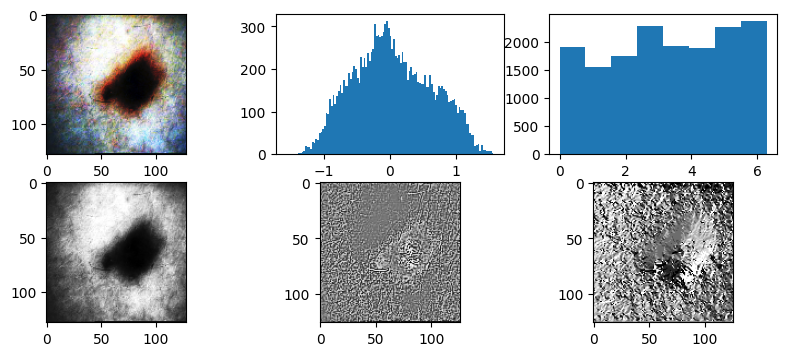

In [16]:
show_excit_and_grad(image)

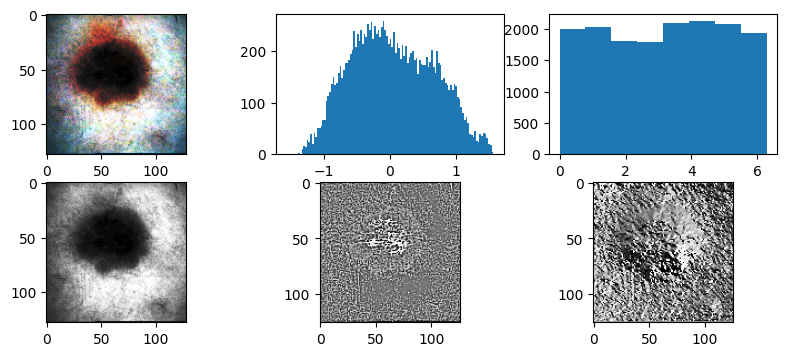

In [17]:
show_excit_and_grad(image_2)

<BarContainer object of 960 artists>

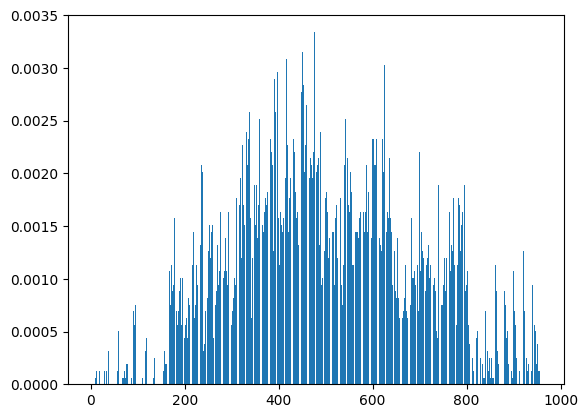

In [18]:
wld = get_wld_histogram(image_name)
plt.bar(range(len(wld)), wld)

<BarContainer object of 960 artists>

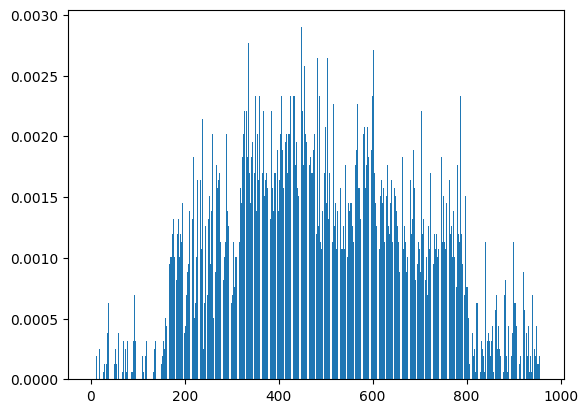

In [19]:
wld_2 = get_wld_histogram(image_name_2)
plt.bar(range(len(wld_2)), wld_2)

In [20]:
histogram_intersection(wld, wld_2), histogram_distance(wld, wld_2)

(0.8529856386999243, 0.14701436130007572)

In [33]:
df = truth_frame#.sample(3000)
targ = df.target

feat = np.array([get_wld_histogram(name)
    for name in tqdm.tqdm(df.image_name)
])

100%|██████████| 3000/3000 [01:06<00:00, 45.00it/s]


In [34]:
from sklearn.model_selection import cross_validate

def scorer(clf, feat, targ):
     pred = clf.predict(feat)
     cm = metrics.confusion_matrix(targ, pred)
     if cm.shape[0] < 2:
          prev = cm
          cm = np.zeros((2,2))
          cm[0, 0] = prev
     return {
          'balanced_acc': metrics.balanced_accuracy_score(targ, pred),
          'tn': cm[0, 0], 'fp': cm[0, 1],
          'fn': cm[1, 0], 'tp': cm[1, 1]
     }

knn = KNeighborsClassifier(n_neighbors=1, metric=histogram_distance)
results = cross_validate(knn, feat, targ, cv=10, scoring=scorer)

In [35]:
results

{'fit_time': array([0.01185679, 0.0115037 , 0.00817609, 0.006464  , 0.00831103,
        0.00777864, 0.00750208, 0.01037002, 0.00604415, 0.00813961]),
 'score_time': array([5.55128884, 6.57080221, 6.20554662, 5.66577482, 5.66905546,
        6.96396613, 6.33819556, 6.18027711, 5.9637711 , 6.31847835]),
 'test_balanced_acc': array([0.61486486, 0.49493243, 0.49831081, 0.49155405, 0.49155405,
        0.49493243, 0.49155405, 0.49831081, 0.49324324, 0.49491525]),
 'test_tn': array([290, 293, 295, 291, 291, 293, 291, 295, 292, 292]),
 'test_fp': array([6, 3, 1, 5, 5, 3, 5, 1, 4, 3]),
 'test_fn': array([3, 4, 4, 4, 4, 4, 4, 4, 4, 5]),
 'test_tp': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [63]:
df = balanced_df
df = truth_frame.sample(10000)

name_train, name_test, targ_train, targ_test = (
    train_test_split(df.image_name, df.target,
                     test_size=0.5, random_state=42))

In [64]:
print(f'{df.target.mean()=}')
print(f'{name_train.shape=}')
print(f'{targ_train.shape=}')
print(f'{targ_train.mean()=}')
print(f'{targ_test.mean()=}')

df.target.mean()=0.0184
name_train.shape=(5000,)
targ_train.shape=(5000,)
targ_train.mean()=0.0194
targ_test.mean()=0.0174


In [86]:
# Undersampling
ones = (targ_train == 1).values
zeros = np.random.choice(a=[True, False], size=targ_train.shape[0], p=[1/3, 2/3])

sample_bools = (ones | zeros)

In [67]:
feat_train = np.array([get_wld_histogram(name)
    for name in tqdm.tqdm(name_train)
])

feat_test = np.array([get_wld_histogram(name)
    for name in tqdm.tqdm(name_test)
])

feat_train.shape, feat_test.shape

100%|██████████| 5000/5000 [01:55<00:00, 43.21it/s]


((5000, 960), (5000, 960))

In [90]:
targ_train[sample_bools].mean()

0.05561926605504587

In [88]:
knn = KNeighborsClassifier(n_neighbors=1, metric=histogram_distance)
# knn.fit(feat_train, targ_train)
knn.fit(feat_train[sample_bools], targ_train[sample_bools])

KNeighborsClassifier(metric=<function histogram_distance at 0x7fca458ad5a0>,
                     n_neighbors=1)

In [89]:
pred = knn.predict(feat_train)
print(f'{pred.mean()=}')
print(f'{metrics.balanced_accuracy_score(targ_train, pred)=}')

metrics.confusion_matrix(targ_train, pred)

pred.mean()=0.0516
metrics.balanced_accuracy_score(targ_train, pred)=0.9835814807260861


array([[4742,  161],
       [   0,   97]])

In [91]:
pred_test = knn.predict(feat_test)

print(f'{pred_test.mean()=}')
print(f'{metrics.balanced_accuracy_score(targ_test, pred_test)=}')

metrics.confusion_matrix(targ_test, pred_test)

pred_test.mean()=0.0554
metrics.balanced_accuracy_score(targ_test, pred_test)=0.559542943773381


array([[4651,  262],
       [  72,   15]])

In [92]:
svc = SVC(kernel='poly', degree=2)
svc = SVC()
svc = SVC(kernel='poly', degree=3)
# svc.fit(feat_train, targ_train)
svc.fit(feat_train[sample_bools], targ_train[sample_bools])

SVC(kernel='poly')

In [93]:
pred = svc.predict(feat_train)
print(f'{pred.mean()=}')
print(f'{metrics.balanced_accuracy_score(targ_train, pred)=}')

metrics.confusion_matrix(targ_train, pred)

pred.mean()=0.0188
metrics.balanced_accuracy_score(targ_train, pred)=0.8163243206873132


array([[4871,   32],
       [  35,   62]])

In [94]:
pred_test = svc.predict(feat_test)

print(f'{pred_test.mean()=}')
print(f'{metrics.balanced_accuracy_score(targ_test, pred_test)=}')

metrics.confusion_matrix(targ_test, pred_test)

pred_test.mean()=0.008
metrics.balanced_accuracy_score(targ_test, pred_test)=0.5310225510082329


array([[4879,   34],
       [  81,    6]])

In [ ]:
img_ast = skimage.data.astronaut()
img_ast = resize_image(img_ast, size=SIZE)
print(f'{img_ast.min(), img_ast.max()=}')
grey = make_greyscale(img_ast)
print(f'{grey.min(), grey.max()=}')

plt.imshow(grey, cmap='hot')
plt.show()

plt.hist(grey.flatten())

In [ ]:
print(f'{grey.max()=}')

arr_00 = apply_f00(grey)
print(f'{arr_00.min()=}')

arr_01 = apply_f01(grey)
# arr_00.shape
div = np.divide(arr_00, arr_01)

plt.hist(arr_00.flatten(), bins=20)
plt.show()
plt.hist(arr_01.flatten(), bins=20)
plt.show()

arr_arc = np.arctan(div)
plt.hist(arr_arc.flatten(), bins=20)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
axs[0].imshow(arr_00)
axs[1].imshow(arr_01)
axs[2].imshow(arr_arc)

In [ ]:
show_excit_and_grad(img_ast)

In [ ]:
# Test

arr = np.array([
    [  0,   0,   0,   0],
    [ 32,  64,  96,  128],
    [100,   1, 100,   1],
    # [255, 255, 255, 255],
])
arr = np.arange(9).reshape(3,3) * 9
arr = np.arange(16).reshape(4,4) * 16
arr = arr[::1, ::1]

# [1,  0,  0],     # [0,  0,  0],
# [0,  0,  0], --> # [0,  0,  0],
# [0,  0,  0]]     # [0,  0,  1]]))

# [0,  1,  0],     # [0,  0,  0],
# [0,  0,  0], --> # [0,  0,  0],
# [0,  0,  0]]     # [0,  1,  0]]))

# [0,  0,  1],     # [0,  0,  0],
# [0,  0,  0], --> # [0,  0,  0],
# [0,  0,  0]]     # [1,  0,  0]]))

# [0,  0,  0],     # [0,  0,  0],
# [1,  0,  0], --> # [0,  0,  1],
# [0,  0,  0]]     # [0,  0,  0]]))

# [0,  0,  0],     # [0,  0,  0],
# [0,  1,  0], --> # [0,  1,  0],
# [0,  0,  0]]     # [0,  0,  0]]))

arr = np.array([[0,  0,  0],
                [0.00001,  0,  0],
                [0,  1,  0]])
                
                
f10 = np.array([[0, -1,  0],
                [0,  0,  0],
                [0,  1,  0]])

f11 = np.array([[0,  0,  0],
                [1,  0, -1],
                [0,  0,  0]])

arr_10 = signal.convolve2d(f10, arr, mode='valid')
arr_11 = signal.convolve2d(f11, arr, mode='valid')

fig, axs = plt.subplots(1, 3, figsize=(8, 4))
axs[0].imshow(arr)
axs[1].imshow(arr_10)
axs[2].imshow(arr_11)

display(arr)
display(arr_11)
display(arr_10)
display(np.arctan2(arr_11[0, 0], arr_10[0,0]))

In [ ]:

arr = np.array([
    [255, 255, 255, 255],
    [255,  64,  64, 255],
    [255,  64,  64, 255],
    [255, 255, 255, 255],
])

arr_11 = apply_f11(arr)
arr_10 = apply_f10(arr)

# fig, axs = plt.subplots(1, 3, figsize=(10, 4))
# axs[0].imshow(arr, cmap='hot')
# axs[1].imshow(arr_11, cmap='hot')
# axs[2].imshow(arr_10, cmap='hot')
# plt.show()

arr_o = np.arctan2(arr_11, arr_10)
# plt.imshow(arr_o, cmap='hot')
# plt.show()
display(arr_o)

T = 8
theta_1 = arr_o + np.pi
display(theta_1)
# t = np.mod(np.floor(), T)
# theta_t = 2*t*np.pi / T

arr_t = get_gradient_orientation(arr)
# plt.imshow(arr_t, cmap='hot')
display(arr_t)

In [ ]:
#pixels = rng.integers(11, size=16).reshape((4, 4))

# labels_grad = [2*np.pi * i for i in range(T)]
# bounds_grad = [2*np.pi / T * (i-1/2) for i in range(T+1)]
# bounds_grad = np.linspace(0, 2*np.pi, T+1)
# bounds_grad

[-3. -1.  1.  3.]


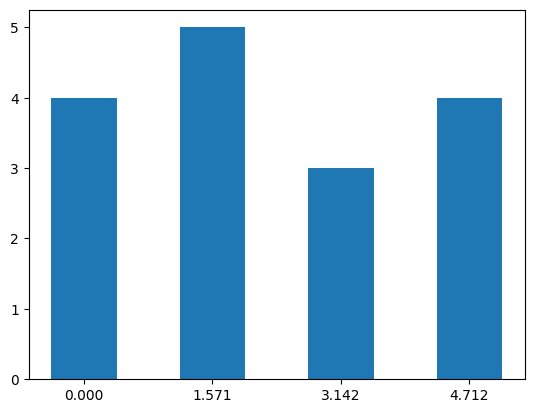

In [76]:
T_ = T
T = 4
import itertools
# Test of np.arctan2
# arr = np.arange(-3, 4)
arr = np.linspace(-3, 3, 4)
print(arr)

items = arr.shape[0]
f = np.zeros(items*items)
s = np.zeros(items*items)


xs = []
ys = []
ts = []
for idx, (x, y) in enumerate(itertools.product(arr, arr)):
    xs.append(x)
    ys.append(y)
    ts.append(big_theta_t(x, y))
    f[idx] = np.arctan2(x, y)
    s[idx] = arctan2(x, y)

unique, counts = np.unique(ts, return_counts=True)
# print('Big Thetas', dict(zip(unique, counts)))

# plt.plot(xs, ys, '.-')
# plt.show()
# plt.hist(ts, bins=8)
plt.bar(unique, counts)
plt.xticks(ticks=unique)

# print(sorted(ts))
# 
# f = f.reshape((items, items))
# s = s.reshape((items, items))
T = T_

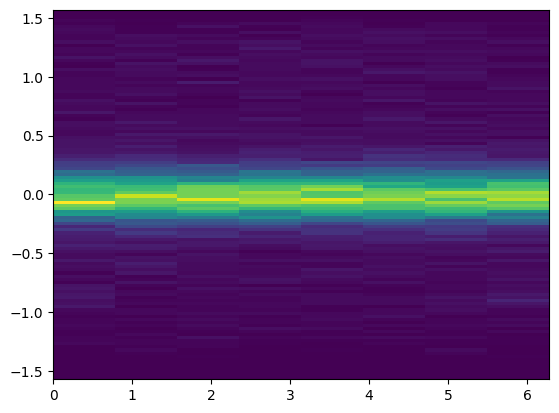

In [126]:
_ = plt.hist2d(grad_ori.flatten(), diff_excit.flatten(), bins=[T, M*S], range=[grad_range, excit_range])

In [163]:
# h[0, 0:20], h[1, 0:20]
# 

<BarContainer object of 960 artists>

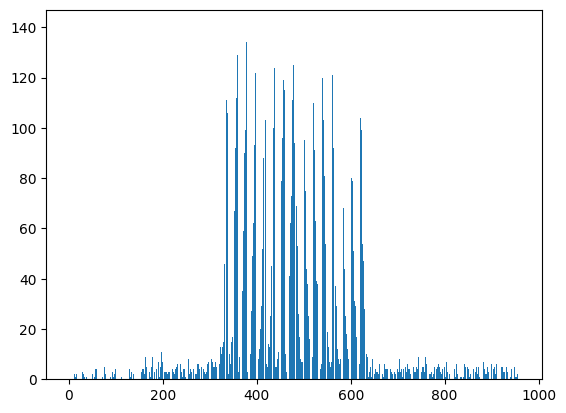

In [168]:
# plt.plot(wld)
# plt.plot(wld, '.')

In [159]:
h[:, 100:120]

array([[5., 0., 1., 3., 7., 2., 3., 3., 0., 5., 2., 2., 3., 4., 3., 1.,
        2., 0., 0., 0.],
       [5., 4., 7., 1., 4., 6., 3., 2., 6., 3., 4., 5., 1., 1., 1., 0.,
        1., 0., 0., 0.],
       [1., 0., 6., 9., 5., 1., 3., 2., 2., 5., 2., 4., 1., 1., 6., 2.,
        0., 0., 0., 0.],
       [4., 4., 4., 3., 4., 5., 3., 9., 5., 7., 2., 0., 5., 0., 1., 4.,
        0., 0., 0., 0.],
       [2., 6., 7., 7., 3., 4., 6., 2., 4., 2., 4., 5., 3., 3., 4., 3.,
        2., 1., 0., 0.],
       [6., 3., 0., 4., 4., 2., 5., 3., 2., 5., 6., 4., 6., 4., 1., 0.,
        1., 0., 0., 0.],
       [4., 5., 3., 5., 4., 3., 5., 3., 3., 2., 5., 2., 5., 3., 3., 3.,
        0., 0., 0., 0.],
       [1., 5., 4., 1., 0., 3., 4., 3., 1., 5., 3., 1., 2., 1., 1., 2.,
        0., 0., 0., 0.]])

In [151]:
x

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714, 6.28318531])

In [144]:
h.T.shape

(120, 8)

In [139]:
df = pd.DataFrame(h)

In [141]:
df

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,2.0,3.0,4.0,3.0,1.0,2.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,...,4.0,5.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,4.0,1.0,1.0,6.0,2.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,5.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,5.0,3.0,3.0,4.0,3.0,2.0,1.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,6.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,...,5.0,2.0,5.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,1.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0


In [137]:
h[:, 0:20]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 2., 2., 1., 1.,
        2., 3., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 3., 1., 2., 2., 1., 3., 1.,
        0., 2., 1., 3.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 2., 2., 2., 6., 0., 1.,
        2., 4., 2., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 2., 0., 2.,
        5., 1., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 3., 1., 1.,
        4., 2., 2., 4.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 1., 4., 0., 3.,
        0., 3., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2., 4., 0., 1., 1., 3., 1., 1.,
        2., 3., 2., 2.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 3.,
        0., 4., 2., 4.]])

In [138]:
x

array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
       3.92699082, 4.71238898, 5.49778714, 6.28318531])

In [134]:
h.shape, x, y, h

((8, 120),
 array([0.        , 0.78539816, 1.57079633, 2.35619449, 3.14159265,
        3.92699082, 4.71238898, 5.49778714, 6.28318531]),
 array([-1.57079633, -1.54461639, -1.51843645, -1.49225651, -1.46607657,
        -1.43989663, -1.41371669, -1.38753676, -1.36135682, -1.33517688,
        -1.30899694, -1.282817  , -1.25663706, -1.23045712, -1.20427718,
        -1.17809725, -1.15191731, -1.12573737, -1.09955743, -1.07337749,
        -1.04719755, -1.02101761, -0.99483767, -0.96865773, -0.9424778 ,
        -0.91629786, -0.89011792, -0.86393798, -0.83775804, -0.8115781 ,
        -0.78539816, -0.75921822, -0.73303829, -0.70685835, -0.68067841,
        -0.65449847, -0.62831853, -0.60213859, -0.57595865, -0.54977871,
        -0.52359878, -0.49741884, -0.4712389 , -0.44505896, -0.41887902,
        -0.39269908, -0.36651914, -0.3403392 , -0.31415927, -0.28797933,
        -0.26179939, -0.23561945, -0.20943951, -0.18325957, -0.15707963,
        -0.13089969, -0.10471976, -0.07853982, -0.05235988, 

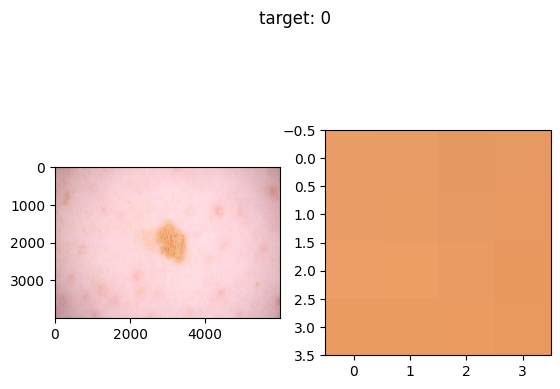

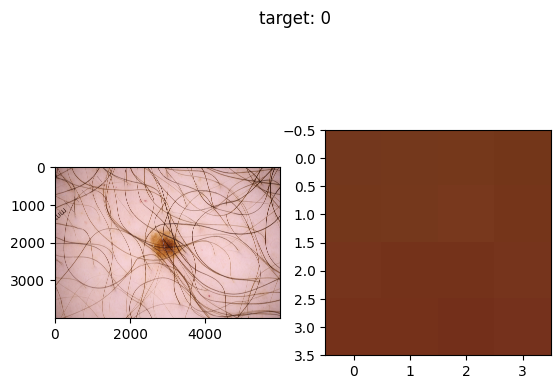

In [20]:
for index, row in sample.sample(2).iterrows():
    fig, axes = plt.subplots(1, 2)
    image = skimage.io.imread(get_image_path(row.image_name))
    axes[0].imshow(image)
    segment_image = make_segment(image, window_size=4)
    axes[1].imshow(segment_image)
    fig.suptitle(f'target: {row.target}')

In [8]:
train_data = sample.sample(10)
train_data

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
9103,ISIC_2822718,IP_0634841,male,50.0,upper extremity,melanoma,malignant,1
23355,ISIC_7101732,IP_6661651,male,60.0,torso,melanoma,malignant,1
4526,ISIC_1464217,IP_1096358,male,45.0,upper extremity,unknown,benign,0
9888,ISIC_3068885,IP_1197949,male,50.0,upper extremity,melanoma,malignant,1
28771,ISIC_8702237,IP_0738123,female,50.0,lower extremity,melanoma,malignant,1
13910,ISIC_4266533,IP_1525419,female,55.0,lower extremity,melanoma,malignant,1
27448,ISIC_8311923,IP_2932439,female,50.0,lower extremity,nevus,benign,0
5656,ISIC_1794022,IP_0951571,female,65.0,lower extremity,unknown,benign,0
16866,ISIC_5157799,IP_1769689,male,40.0,lower extremity,unknown,benign,0
21294,ISIC_6461419,IP_3858753,male,35.0,torso,unknown,benign,0


In [10]:
train_targets, train_image_names = (
    train_data.target.values.astype('u1'), train_data.image_name.values )

features = []

for idx, image_name in train_data.image_name.items():
    image = skimage.io.imread(get_image_path(image_name))
    features.append(make_features(image, window_size=4))

train_features = np.array(features)
train_features.shape, train_targets.shape

((10, 48), (10,))

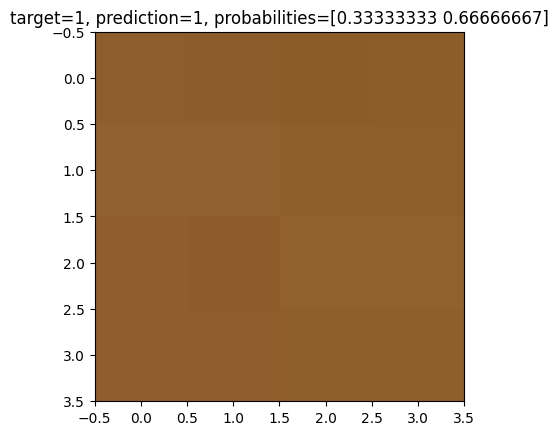

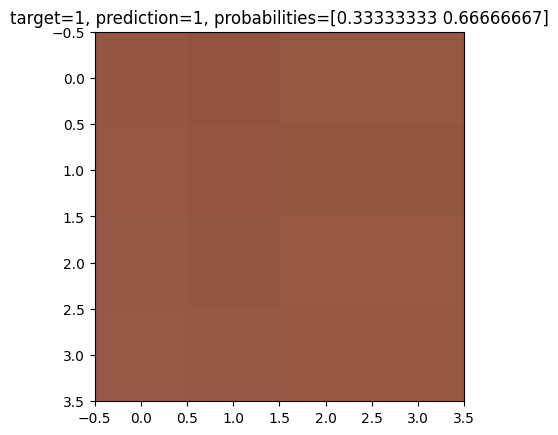

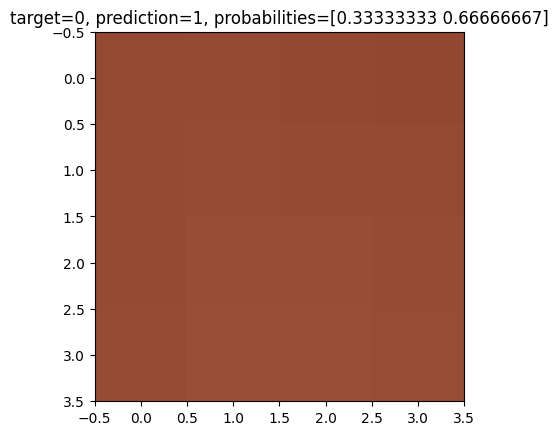

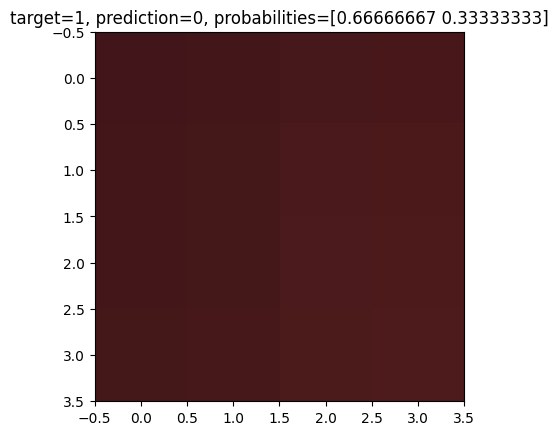

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_features, train_targets)

for target, features, prediction, probabilities in list(zip(
            train_targets,
            train_features,
            knn.predict(train_features),
            knn.predict_proba(train_features)
        ))[:4]:
    # print(target, pred, prob)
    image = np.reshape(features, (4, 4, 3))
    plt.imshow(image)
    plt.title(f'target={target}, prediction={prediction}, probabilities={probabilities}')
    plt.show()